# Text Classification with NLTK and Scikit-Learn

+ Last class, we saw how we'd go about using scikit-learn.
+ This class, we'll apply this to something concrete.

# Getting Started

If you want to follow along, make sure that you have NLTK and Scikit-Learn installed, and that you have downloaded the NLTK corpus:

In [ ]:
%%sh 

pip install nltk scikit-learn
python -m nltk.downloader all

# General Pipeline 
![image](https://user-images.githubusercontent.com/1433964/46770917-53b52380-ccbf-11e8-9195-216d96cd887f.png)

## What do these mean?
+ **The Corpus Reader:** Read files one at a and act as the source of the data. 
+ **The Tokenizer:** Split raw text into sentences, words and punctuation, then tag their part of speech and lemmatizes them using the WordNet lexicon. 
+ **The vectorizer:** Encodes the tokens in the document as a feature vector, for example as a TF-IDF vector. 
+ **The classifier:** Fit to the documents and their labels and to make predictions.

## 1. Reading a corpus

+ A simple corpus that comes pre-installed with ntlk.
+ Has 200 movie review text and corresponding lables:
    - Positive
    - Negative
+ Let's take a look:

In [78]:
from nltk.corpus import movie_reviews as reviews
import numpy as np

X = [reviews.raw(fileid) for fileid in reviews.fileids()]
y = np.array([reviews.categories(fileid)[0]!='neg' for fileid in reviews.fileids()]).astype(np.int)

print(X[1], y[4])

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

![image](https://user-images.githubusercontent.com/1433964/46770902-413aea00-ccbf-11e8-97b1-3d382194018c.png)

## 2. Preprocessing: Tokenize, Lemmatize, etc.

+ Now that we have read the corpus, we need to preprocess the string to tokenize it, and lemmatize it.

+ Basically, 
    - We want to convert "A sentence of words" to `["A", "sentence", "of", "words"]`
    - Next, we want to combine redundant features into a single token.
        - E.g, `bunny`, `bunnies`, `bunny's`, `Bunny`, and `bunny!` all become `bunny`
    - We also want to remove stopwords like "A", "of", etc.
    - We don't much care for punctuations, uppercase letters, numbers, etc.


+ Let's see how we'd do that.

In [43]:
import string

from nltk.corpus import stopwords 
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag


# ----------------------------------
# ----- TOKENIZE A DOCUMENT --------
# ----------------------------------

def tokenize(document):
    lemmatizer = WordNetLemmatizer()
    
    "Break the document into sentences"
    for sent in sent_tokenize(document):

        "Break the sentence into part of speech tagged tokens"
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            
            "Apply preprocessing to the token"
            token = token.lower()  # Convert to lower case
            token = token.strip()  # Strip whitespace and other punctuations
            token = token.strip('_')  # remove _ if any
            token = token.strip('*')  # remove * if any

            "If stopword, ignore."
            if token in stopwords.words('english'):
                continue

            "If punctuation, ignore."
            if all(char in string.punctuation for char in token):
                continue

            "If number, ignore."
            if token.isdigit():
                continue

            # Lemmatize the token and yield
            # Note: Lemmatization is the process of looking up a single word form 
            # from the variety of morphologic affixes that can be applied to 
            # indicate tense, plurality, gender, etc.
            lemma = lemmatizer.lemmatize(token)
            yield lemma

### The Original String:

In [ ]:
print(X[0])

### Becomes

In [ ]:
print([tok for tok in tokenize(X[0])])

![image](https://user-images.githubusercontent.com/1433964/46770872-1cdf0d80-ccbf-11e8-89ea-ca7529ecb19b.png)

## 3. Scikit-Learn Vectorization

+ Just a list of words is of not much use, we need to vectorize these words to be able to do classification.
+ TF-IDF is a popular vectorizer

### What is TF-IDF?
+ Convert a word into a number based on the following:

###### Term Frequency
```
TermFrequency(word)
  No. of times the word appears in one document
```
###### Document Frequency
```
DocumentFrequecy(word)

    No. times the word appears in all the documents 
    -----------------------------------------------
                  No. of Documents              
```

+ Intuition,
  - Words that appear more often in a document are useful.
  - Words that appear least often in all documents are useful.


##### Example

+ Take the following two sentences
    1. *"Something about a cat."*
    2. *"Something about a dog."*
+ `TF("cat")` = 1
+ `DF("cat")` = 1/2 = 0.5
+ `TFIDF("cat") = TF("cat") / DF("cat")`
    `TFIDF("cat") = 1 / 0.5 = 2`

+ `TF("something")` = 1
+ `DF("something")` = 2/2 = 1
+ `TFIDF("cat") = TF("cat") / DF("cat")`
    `TFIDF("cat") = 1 / 1 = 1`


**`TFIDF("cat")=2` and `TFIDF("something")=1`**

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenize all the documents in the corpus
# ----------------------------------------
tokenize_corpus = [tokenize(x) for x in X]

# Vectorize with TFIDF
# ====================

# 1. Instantiate TfidfVectorizer
# ------------------------------
vectorizer = TfidfVectorizer(tokenizer=tokenize, preprocessor=None, lowercase=False)
                                    #---------#
                # We to pass our tokenizer that we wrote above.#
    

# 2. Generate TFIDF Matrix
# ------------------------
# + **Remember: Use fit_transform NOT fit.**
# + vectorizer.fit(X) will only compute vocubulary. 
# + vectorizer.fit_transform(X) will compute vocubulary, compute TFIDF, 
# and return a transformed matrix. 

# NOTE: This will take a while......
X_tfidf = vectorizer.fit_transform(X)

In [94]:
X_tfidf[0]

<1x34553 sparse matrix of type '<class 'numpy.float64'>'
	with 239 stored elements in Compressed Sparse Row format>

![image](https://user-images.githubusercontent.com/1433964/46770839-00db6c00-ccbf-11e8-93f1-b6219556d22a.png)

## 4. Scikit Learn Classification 

We've seen this before. So let's build a classifier.

### Let's classify first with SVM

In [106]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.base import clone  

# Stratification attempts to maintain the realtive ratios
# of positive and negative classes in each of folds.
# This is very helpful for skewed datasets (read: SE Data)
skfolds = StratifiedKFold(n_splits=10, random_state=0)

# Create and instance of your classifier
clf = LinearSVC(C=1, loss='hinge')  

# Store F1, precision, and recall for svm
svm_f1   = []
svm_prec = []
svm_recl = []

fold = 0

for train_index, test_index in skfolds.split(X_tfidf, y):
    # Deep copy here, when you do cross-validation, it's always a good idead
    # not to mess with the original classifier. 

    # We need a "clean" classifier for every fold. Otherwise your mixing the
    # training and testing data form different folds. That's a no-no.
    cloned_clf = clone(clf)

    # Training data
    # -------------
    X_train_folds = X_tfidf[train_index]
    y_train_folds = y[train_index]

    # Testing data
    # ------------
    X_test_folds = X_tfidf[test_index]
    y_test_folds = y[test_index]

    # Fit a classifier on the training data
    # -------------------------------------
    cloned_clf.fit(X_train_folds, y_train_folds)

    # Make predictions on a test set
    # ------------------------------
    y_hat = cloned_clf.predict(X_test_folds)

    # Compute some metrics here. Like Precision, Recall, False Alarm, or what have you.
    # ---------------------------------------------------------------------------------
    cmat = confusion_matrix(y_test_folds, y_hat)

    # Precision
    # ---------
    prec = cmat[1,1]/(cmat[1,1]+cmat[0,1])

    # Recall
    # ------
    recall = cmat[1,1]/(cmat[1,1]+cmat[1,0])
    
    # F1 Score
    # --------
    f1 = 2*(prec*recall)/(prec+recall)
    
    # Record results
    # --------------
    
    svm_f1.append(f1)
    svm_prec.append(prec)
    svm_recl.append(recall)
        

### Now let's do Stochastic Gradient Descent

In [112]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.base import clone  

# Stratification attempts to maintain the realtive ratios
# of positive and negative classes in each of folds.
# This is very helpful for skewed datasets (read: SE Data)
skfolds = StratifiedKFold(n_splits=10, random_state=0)

# Create and instance of your classifier
clf = SGDClassifier(random_state=0, max_iter=10, tol=1e3)  

# Store F1, precision, and recall for svm
sgd_f1   = []
sgd_prec = []
sgd_recl = []

for train_index, test_index in skfolds.split(X_tfidf, y):
    # Deep copy here, when you do cross-validation, it's always a good idead
    # not to mess with the original classifier. 

    # We need a "clean" classifier for every fold. Otherwise your mixing the
    # training and testing data form different folds. That's a no-no.
    cloned_clf = clone(clf)

    # Training data
    # -------------
    X_train_folds = X_tfidf[train_index]
    y_train_folds = y[train_index]

    # Testing data
    # ------------
    X_test_folds = X_tfidf[test_index]
    y_test_folds = y[test_index]

    # Fit a classifier on the training data
    # -------------------------------------
    cloned_clf.fit(X_train_folds, y_train_folds)

    # Make predictions on a test set
    # ------------------------------
    y_hat = cloned_clf.predict(X_test_folds)

    # Compute some metrics here. Like Precision, Recall, False Alarm, or what have you.
    # ---------------------------------------------------------------------------------
    cmat = confusion_matrix(y_test_folds, y_hat)

    # Precision
    # ---------
    prec = cmat[1,1]/(cmat[1,1]+cmat[0,1])

    # Recall
    # ------
    recall = cmat[1,1]/(cmat[1,1]+cmat[1,0])
    
    # F1 score
    # --------
    f1 = 2*(prec*recall)/(prec+recall)
    
    # Record results
    # --------------
    
    sgd_f1.append(f1)
    sgd_prec.append(prec)
    sgd_recl.append(recall)

## Now Let's Compare

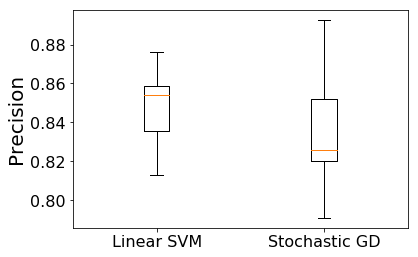

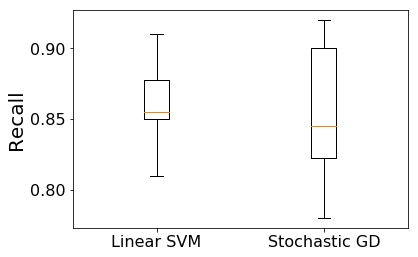

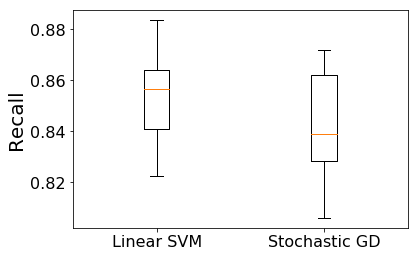

In [114]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Setup Matplotlib
# ----------------

# Font sizes
# ----------
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 36
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(6,4))
plt.boxplot([svm_prec, sgd_prec], labels=['Linear SVM', 'Stochastic GD'])
plt.ylabel('Precision')
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([svm_recl, sgd_recl], labels=['Linear SVM', 'Stochastic GD'])
plt.ylabel('Recall')
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([svm_f1, sgd_f1], labels=['Linear SVM', 'Stochastic GD'])
plt.ylabel('Recall')
plt.show()

![image](https://user-images.githubusercontent.com/1433964/46771960-c9bb8980-ccc3-11e8-9eef-95a4c621f2a1.png)